## p-y for sand

# Notes

Need to run the code below again to reinstall the package

```shell
pip install -e . 
```

The code has been moved to the source folder for house keeping

In [6]:
from src.cpt import CPT
from pathlib import Path
import os
import plotly.io as pio
import numpy as np
import pandas as pd
from numpy import degrees, log10, pi, radians, tan, sin, cos
from src.p_y_sand import *
from src.pile import PipePile

### Import data from CPT file
#### - Data format - 

`key` is the identifier in the txt file, for locating the data, it shoudl be a unit identifier just above the data
`patter` - an regular experss to specify the pattern of the data, you can see the example below

After reading the data, need to change the column name, so that all calculation can know the location of the data

#### - Rename Columns - 
```python
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
```

- `SCPT_DPTH` - depth below seabed
- `SCPT_RES` - raw `qc` value
- `SCPT_FRES` - shaft resistance $f_s$
- `SCPT_RES` - tip resistance $q_c$

#### - Specify Unit - 

Need to update the unit, differnet contactor may output data in different unit, this is one by 

```python
cpt_data.set_data_unit(['MPa','MPa','MPa'])
```

unit is assigned in a sequence [$q_c$, $f_s$,$u_2$]

#### - init_CPT - 

This is calculate $\gamma_{soil}$ and calculate the overburnden stress $\sigma_v$ 


In [77]:
filename ='CPT4.A00'
fileloc = Path(r'G:\Name Folders\Current Staff\CC213\10 IiA funding\Unified CPT Methods\01 Data\CPT Data\18 0091 05 R002 CPT ASCII')

cpt_data = CPT()
cpt_data.read_ASCII(fileloc / filename,key='Data--',pattern= r'(.{7})(.{10})(.{11})(.{11})(.{11})(.{11})(.{11})')
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
cpt_data.set_data_unit(['MPa','MPa','MPa'])
cpt_data.init_CPT()

23-10-18 11:34:56 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\dlpkg\cpt.py:327 DEBUG - Data unit is set to ['MPa', 'MPa', 'MPa']
c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\dlpkg\cpt.py:591: RuntimeWarning:

invalid value encountered in log10

23-10-18 11:34:58 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\dlpkg\cpt.py:156 DEBUG - qt calculated using net area ratio of 0.85


In [78]:
cpt_data.df

,Reading,SCPT_DPTH,SCPT_RES,SCPT_FRES,SCPT_PWP2,slopex,slopey,qt,Rf,gamma,...,qnet,Bq,Qt1,Fr,Ic,n,Qtn,k,M,Dr
0,937,0.000,0.0000,NaN,NaN,5.7398,5.9407,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,938,0.007,0.0012,NaN,NaN,5.7493,5.9575,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,939,0.015,0.0014,NaN,0.1,5.7568,5.9609,0.001415,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,940,0.022,0.0020,NaN,0.2,5.7479,5.9625,0.002030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,941,0.030,0.0033,NaN,0.4,5.7262,5.9470,0.003360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7446,12036,74.256,36.9960,171.1,603.0,9.5273,7.1031,37.086450,0.461354,20.267859,...,35.750334,-0.003904,60.230813,0.478597,1.802602,0.834103,80.757930,0.000030,315.405205,56.130529
7447,12037,74.265,37.1310,173.4,613.4,9.5384,7.0817,37.223010,0.465841,20.284611,...,35.886773,-0.003602,60.457450,0.483186,1.803496,0.834456,81.011971,0.000029,316.967698,56.227810
7448,12038,74.271,37.4581,174.4,599.5,9.5219,7.0552,37.548025,0.464472,20.294550,...,36.211605,-0.003955,60.992083,0.481614,1.798146,0.832485,82.016529,0.000031,317.677046,56.458969
7449,12039,74.280,37.4564,178.2,608.9,9.5449,7.0422,37.547735,0.474596,20.319316,...,36.211234,-0.003698,60.992354,0.492112,1.804459,0.834874,81.671007,0.000029,320.223942,56.457947


### Determine soil type based on Ic
Ic<2.6 for sand, >2.6 for clay

In [90]:
def interpolate_cpt_data(cpt_data):
    new_depths = pd.Series(range(int(cpt_data['SCPT_DPTH'].min()), int(cpt_data['SCPT_DPTH'].max())+1))
    new_df = pd.DataFrame({'SCPT_DPTH': new_depths})
    new_df = new_df.merge(cpt_data, how='left', on='SCPT_DPTH')
    new_df['SCPT_RES'] = new_df['SCPT_RES'].interpolate()
    return new_df

interpolate_cpt_data(cpt_data.df)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1127: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation



,SCPT_DPTH,Reading,SCPT_RES,SCPT_FRES,SCPT_PWP2,slopex,slopey,qt,Rf,gamma,...,qnet,Bq,Qt1,Fr,Ic,n,Qtn,k,M,Dr
0,0,937.0,0.000000,NaN,NaN,5.7398,5.9407,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.038720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,0.077440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,0.116160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,0.154880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,NaN,22.039700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,71,NaN,23.007525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,72,NaN,23.975350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,73,NaN,24.943175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
cpt_data.df ['soil_type'] = cpt_data.df.apply(lambda row:determine_soil_type(ic = row['Ic']), axis = 1)

### Calculate p-y parameters for sand

In [75]:
cpt_data.df ['phi_e'] = cpt_data.df.apply(lambda row:calc_phi_e(qt = row['qt'], sigma_v = row['sigma_v'], sigma_v_e = row['sigma_v_e']) if row['soil_type'] == 'sand' else None, axis = 1)
cpt_data.df ['C1'] = cpt_data.df.apply(lambda row:calc_C1(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
cpt_data.df ['C2'] = cpt_data.df.apply(lambda row:calc_C2(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
cpt_data.df ['C3'] = cpt_data.df.apply(lambda row:calc_C3(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
cpt_data.df ['k'] = cpt_data.df.apply(lambda row:calc_k(phi_e = row['phi_e']) if row['soil_type'] == 'sand' else None, axis = 1)
cpt_data.df ['pr'] = cpt_data.df.apply(lambda row:calc_pr(D = 2.0, gamma = row['gamma'], z = row['SCPT_DPTH'], C1 = row['C1'], C2 = row['C2'], C3 = row['C3']) if row['soil_type'] == 'sand' else None, axis = 1)
cpt_data.df ['A'] = cpt_data.df.apply(lambda row:calc_A(D = 2.0, z = row['SCPT_DPTH'], loading = 'Monotonic') if row['soil_type'] == 'sand' else None, axis = 1)

In [ ]:
D = 2.0
loading = 'Monotonic'
nkt = 12
N1 = 12
N2 = 3.22

### Generate p-y curves for sand

In [72]:
# Generate p-y curves using specified y values
for i in range(11):
    cpt_data.df[f'y{i}'] = 10 * i
    cpt_data.df[f'p{i}'] = cpt_data.df.apply(lambda row:calc_p(y = row[f'y{i}'], A = row['A'], pr = row['pr'], z = row['SCPT_DPTH'], k = row['k']) if row['soil_type'] == 'sand' else None, axis = 1)

In [73]:
cpt_data.df['soil_type']

0        N/A
1        N/A
2        N/A
3        N/A
4        N/A
        ... 
7446    sand
7447    sand
7448    sand
7449    sand
7450    sand
Name: soil_type, Length: 7451, dtype: object

### Export results and plot figures

cpt_data.xlsx has been exported successfully.


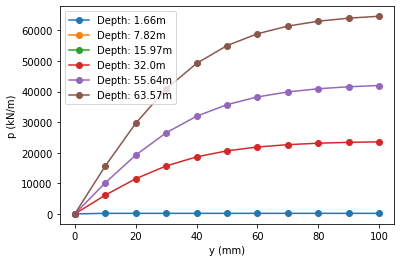

0

In [74]:
export_p_y_sand(cpt_data.df, "cpt_data.xlsx")
plot_p_y_curve(cpt_data, [200, 800, 1600, 3200, 5600, 6400])